In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [3]:
x = np.zeros((5000,2))


np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

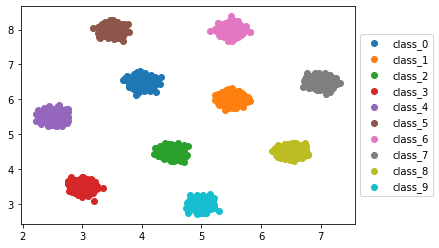

In [4]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

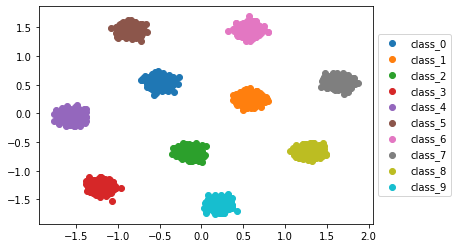

In [8]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
bg_mean = np.mean(x[1500:],axis=0,keepdims=True)
bg_std = np.std(x[1500:],axis=0,keepdims=True)
x = (x - bg_mean) / bg_std

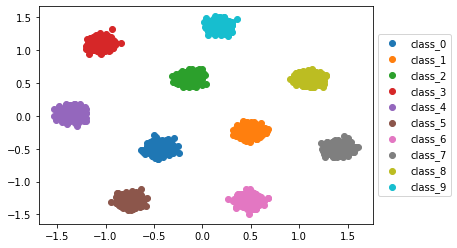

In [12]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [10]:
desired_num = 3000  # 2000 + 1000


m = 500



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|███████████████████████████████████████| 3000/3000 [00:42<00:00, 71.19it/s]


In [11]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches dimension 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/500 , bg_image_ratio = (500-j)/499*500
  """
  avg_image_dataset = []
  for i in tqdm(range(len(mosaic_dataset))):
    img = torch.zeros([2], dtype=torch.float64)
    for j in range(m):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/(m)
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*(m))
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [12]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 1,500)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 12,500)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 25,500)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 50,500 )
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 100,500)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 150,500)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] ,200,500)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 250,500)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 300,500)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 350,500)
avg_image_dataset_11 , labels_11,  fg_index_11 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 400,500)
avg_image_dataset_12 , labels_12,  fg_index_12 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 450,500)
avg_image_dataset_13 , labels_13,  fg_index_13 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000], fore_idx[0:2000] , 500,500)
avg_image_dataset_14 , labels_14,  fg_index_14= create_avg_image_from_mosaic_dataset(mosaic_list_of_images[2000:], mosaic_label[2000:], fore_idx[2000:] , 500,500)

100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.93it/s]


In [13]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1,dim=0)
avg_image_dataset_2 = torch.stack(avg_image_dataset_2,dim=0)
avg_image_dataset_3 = torch.stack(avg_image_dataset_3,dim=0)
avg_image_dataset_4 = torch.stack(avg_image_dataset_4,dim=0)
avg_image_dataset_5 = torch.stack(avg_image_dataset_5,dim=0)
avg_image_dataset_6 = torch.stack(avg_image_dataset_6,dim=0)
avg_image_dataset_7 = torch.stack(avg_image_dataset_7,dim=0)
avg_image_dataset_8 = torch.stack(avg_image_dataset_8,dim=0)
avg_image_dataset_9 = torch.stack(avg_image_dataset_9,dim=0)
avg_image_dataset_10 = torch.stack(avg_image_dataset_10,dim=0)
avg_image_dataset_11 = torch.stack(avg_image_dataset_11,dim=0)
avg_image_dataset_12 = torch.stack(avg_image_dataset_12,dim=0)
avg_image_dataset_13 = torch.stack(avg_image_dataset_13,dim=0)
avg_image_dataset_14 = torch.stack(avg_image_dataset_14,dim=0)


Text(0.5, 1.0, 'Dataset 14')

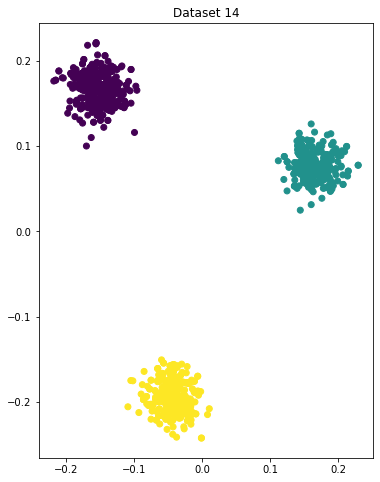

In [14]:
plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_14[:,0],avg_image_dataset_14[:,1],c=labels_14)
plt.title("Dataset 14")


In [15]:
avg_image_dataset_14 = avg_image_dataset_14/m

Text(0.5, 1.0, 'Dataset 14')

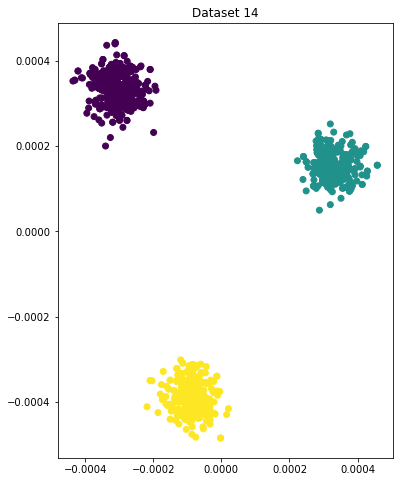

In [16]:
plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_14[:,0],avg_image_dataset_14[:,1],c=labels_14)
plt.title("Dataset 14")


Text(0.5, 1.0, 'Dataset 14')

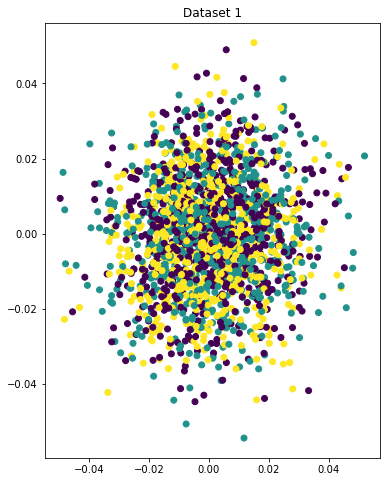

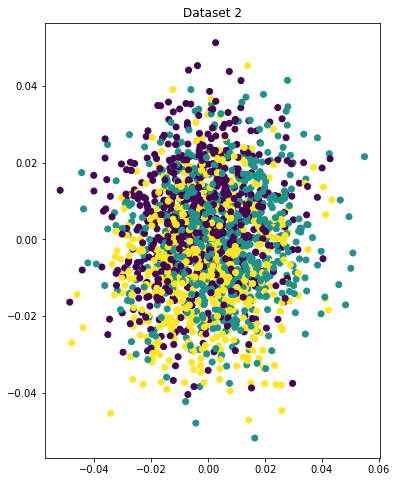

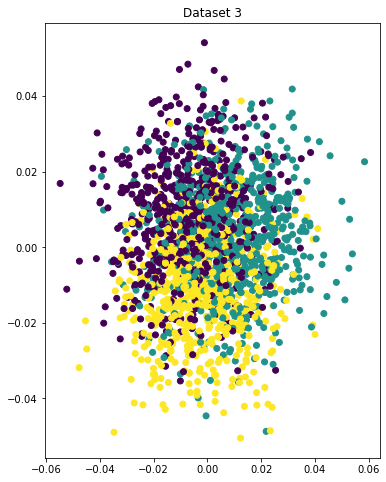

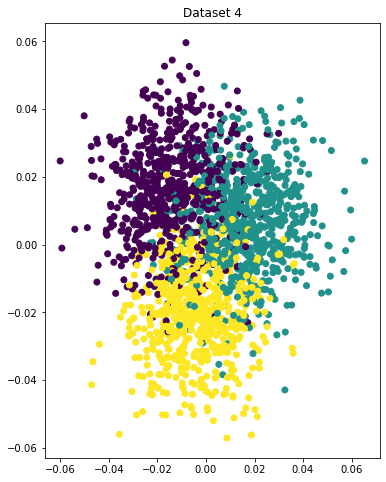

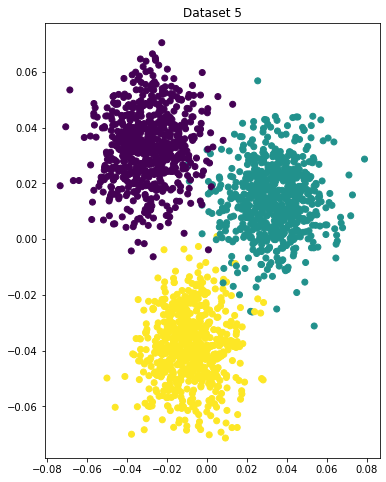

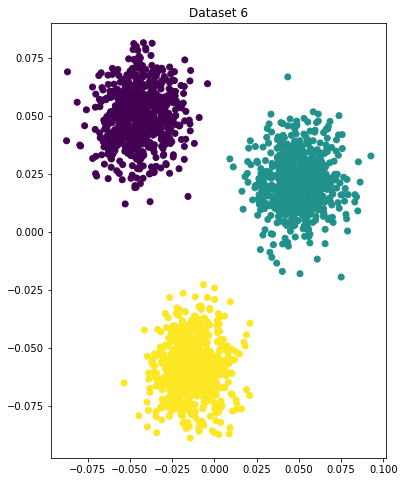

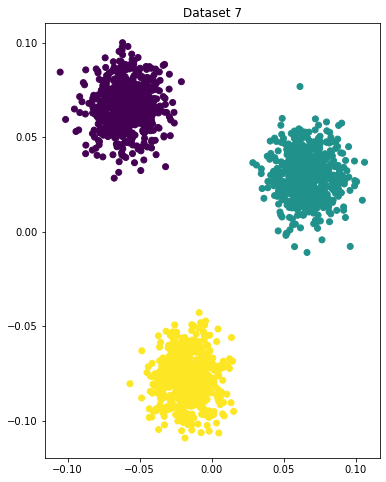

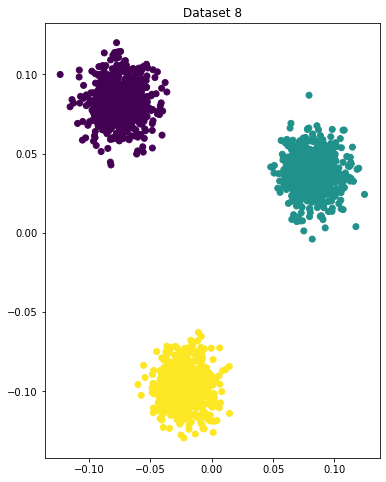

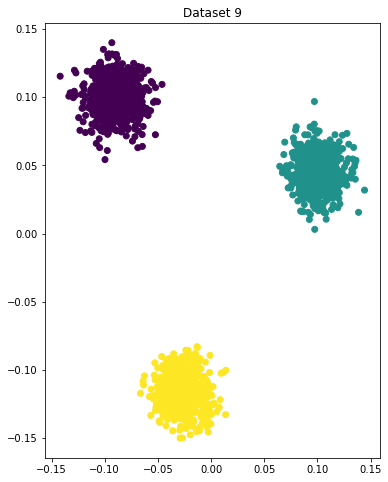

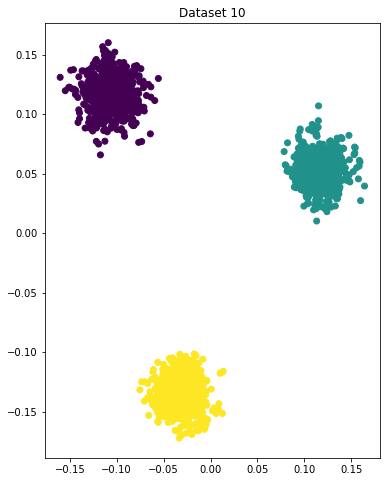

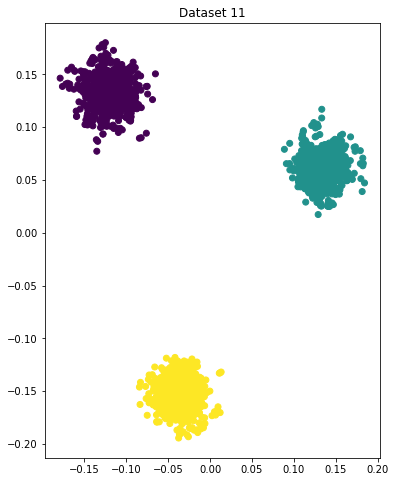

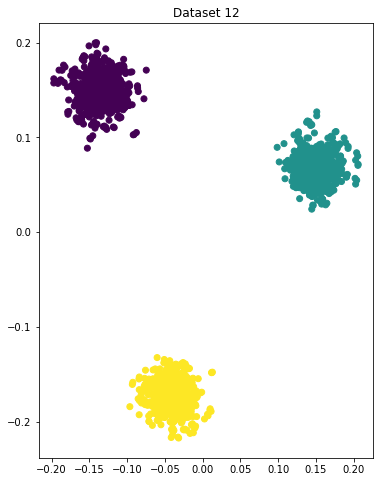

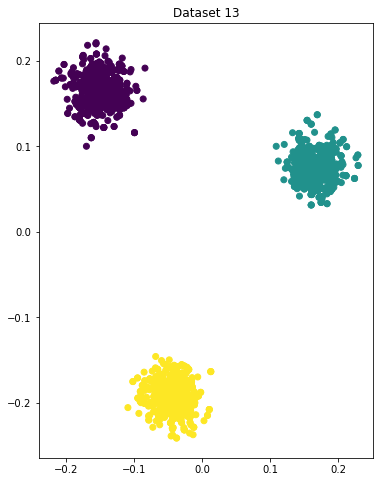

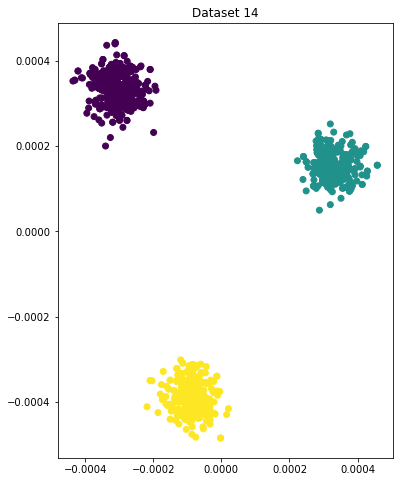

In [17]:
plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_1[:,0],avg_image_dataset_1[:,1],c=labels_1)
plt.title("Dataset 1")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_2[:,0],avg_image_dataset_2[:,1],c=labels_2)
plt.title("Dataset 2")



plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_3[:,0],avg_image_dataset_3[:,1],c=labels_3)
plt.title("Dataset 3")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_4[:,0],avg_image_dataset_4[:,1],c=labels_4)
plt.title("Dataset 4")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_5[:,0],avg_image_dataset_5[:,1],c=labels_5)
plt.title("Dataset 5")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_6[:,0],avg_image_dataset_6[:,1],c=labels_6)
plt.title("Dataset 6")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_7[:,0],avg_image_dataset_7[:,1],c=labels_7)
plt.title("Dataset 7")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_8[:,0],avg_image_dataset_8[:,1],c=labels_8)
plt.title("Dataset 8")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_9[:,0],avg_image_dataset_9[:,1],c=labels_9)
plt.title("Dataset 9")

plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_10[:,0],avg_image_dataset_10[:,1],c=labels_10)
plt.title("Dataset 10")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_11[:,0],avg_image_dataset_11[:,1],c=labels_11)
plt.title("Dataset 11")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_12[:,0],avg_image_dataset_12[:,1],c=labels_12)
plt.title("Dataset 12")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_13[:,0],avg_image_dataset_13[:,1],c=labels_13)
plt.title("Dataset 13")


plt.figure(figsize=(6,8))
plt.scatter(avg_image_dataset_14[:,0],avg_image_dataset_14[:,1],c=labels_14)
plt.title("Dataset 14")


In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [19]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
trainloader_11 = DataLoader( traindata_11 , batch_size= batch ,shuffle=True)

traindata_12 = MosaicDataset(avg_image_dataset_12, labels_12)
trainloader_12 = DataLoader( traindata_12, batch_size= batch ,shuffle=True)

traindata_13 = MosaicDataset(avg_image_dataset_13, labels_13)
trainloader_13 = DataLoader( traindata_13 , batch_size= batch ,shuffle=True)




testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12)
testloader_12 = DataLoader( testdata_12 , batch_size= batch ,shuffle=False)

testdata_13 = MosaicDataset(avg_image_dataset_13, labels_13 )
testloader_13 = DataLoader( testdata_13 , batch_size= batch ,shuffle=False)

testdata_14 = MosaicDataset(avg_image_dataset_14, labels_14)
testloader_14 = DataLoader( testdata_14 , batch_size= batch ,shuffle=False)

In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [21]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [22]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 300
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch ==0:
            with torch.no_grad():
                for k, data in enumerate(trainloader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device),labels.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    if k+1 ==8:
                        ep_lossi.append(running_loss/(k+1))
                        print('[%d, %5d] loss: %.3f' %(epoch, k+ 1, running_loss/(k+1) ))
                        running_loss = 0.0  
                loss_curi.append(np.mean(ep_lossi))
                ep_lossi = [] 

                    
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 8
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    print('Finished Training')
    torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi


In [23]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12,testloader_13,testloader_14]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))
train_loss_all.append(train_all(trainloader_11, 11, testloader_list))
train_loss_all.append(train_all(trainloader_12, 12, testloader_list))
train_loss_all.append(train_all(trainloader_13, 13, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
[0,     8] loss: 1.099
[1,     8] loss: 1.099
[2,     8] loss: 1.099
[3,     8] loss: 1.099
[4,     8] loss: 1.099
[5,     8] loss: 1.099
[6,     8] loss: 1.099
[7,     8] loss: 1.099
[8,     8] loss: 1.099
[9,     8] loss: 1.099
[10,     8] loss: 1.098
[11,     8] loss: 1.098
[12,     8] loss: 1.098
[13,     8] loss: 1.098
[14,     8] loss: 1.098
[15,     8] loss: 1.098
[16,     8] loss: 1.098
[17,     8] loss: 1.098
[18,     8] loss: 1.098
[19,     8] loss: 1.098
[20,     8] loss: 1.098
[21,     8] loss: 1.098
[22,     8] loss: 1.098
[23,     8] loss: 1.098
[24,     8] loss: 1.098
[25,     8] loss: 1.098
[26,     8] loss: 1.098
[27,     8] loss: 1.098
[28,     8] loss: 1.098
[29,     8] loss: 1.098
[30,     8] loss: 1.098
[31,     8] loss: 1.098
[32,     8] loss: 1.098
[33,     8] loss: 1.098
[34,     8] loss: 1.098
[35,     8] loss: 1.098
[36,     8] loss: 1.098
[37,     8] loss

[1,     8] loss: 1.099
[2,     8] loss: 1.098
[3,     8] loss: 1.097
[4,     8] loss: 1.097
[5,     8] loss: 1.097
[6,     8] loss: 1.096
[7,     8] loss: 1.096
[8,     8] loss: 1.095
[9,     8] loss: 1.095
[10,     8] loss: 1.094
[11,     8] loss: 1.094
[12,     8] loss: 1.093
[13,     8] loss: 1.093
[14,     8] loss: 1.093
[15,     8] loss: 1.092
[16,     8] loss: 1.092
[17,     8] loss: 1.091
[18,     8] loss: 1.091
[19,     8] loss: 1.091
[20,     8] loss: 1.090
[21,     8] loss: 1.090
[22,     8] loss: 1.089
[23,     8] loss: 1.089
[24,     8] loss: 1.089
[25,     8] loss: 1.088
[26,     8] loss: 1.088
[27,     8] loss: 1.088
[28,     8] loss: 1.087
[29,     8] loss: 1.087
[30,     8] loss: 1.086
[31,     8] loss: 1.086
[32,     8] loss: 1.085
[33,     8] loss: 1.085
[34,     8] loss: 1.085
[35,     8] loss: 1.084
[36,     8] loss: 1.084
[37,     8] loss: 1.084
[38,     8] loss: 1.083
[39,     8] loss: 1.083
[40,     8] loss: 1.083
[41,     8] loss: 1.082
[42,     8] loss: 1.082
[

[4,     8] loss: 1.095
[5,     8] loss: 1.094
[6,     8] loss: 1.093
[7,     8] loss: 1.092
[8,     8] loss: 1.091
[9,     8] loss: 1.090
[10,     8] loss: 1.089
[11,     8] loss: 1.088
[12,     8] loss: 1.087
[13,     8] loss: 1.086
[14,     8] loss: 1.085
[15,     8] loss: 1.084
[16,     8] loss: 1.083
[17,     8] loss: 1.082
[18,     8] loss: 1.081
[19,     8] loss: 1.080
[20,     8] loss: 1.080
[21,     8] loss: 1.078
[22,     8] loss: 1.077
[23,     8] loss: 1.077
[24,     8] loss: 1.076
[25,     8] loss: 1.075
[26,     8] loss: 1.074
[27,     8] loss: 1.073
[28,     8] loss: 1.072
[29,     8] loss: 1.071
[30,     8] loss: 1.070
[31,     8] loss: 1.069
[32,     8] loss: 1.068
[33,     8] loss: 1.068
[34,     8] loss: 1.067
[35,     8] loss: 1.066
[36,     8] loss: 1.065
[37,     8] loss: 1.064
[38,     8] loss: 1.063
[39,     8] loss: 1.063
[40,     8] loss: 1.061
[41,     8] loss: 1.061
[42,     8] loss: 1.060
[43,     8] loss: 1.059
[44,     8] loss: 1.058
[45,     8] loss: 1.05

[26,     8] loss: 1.048
[27,     8] loss: 1.046
[28,     8] loss: 1.044
[29,     8] loss: 1.042
[30,     8] loss: 1.040
[31,     8] loss: 1.038
[32,     8] loss: 1.036
[33,     8] loss: 1.035
[34,     8] loss: 1.033
[35,     8] loss: 1.031
[36,     8] loss: 1.029
[37,     8] loss: 1.027
[38,     8] loss: 1.025
[39,     8] loss: 1.024
[40,     8] loss: 1.022
[41,     8] loss: 1.020
[42,     8] loss: 1.018
[43,     8] loss: 1.017
[44,     8] loss: 1.015
[45,     8] loss: 1.013
[46,     8] loss: 1.011
[47,     8] loss: 1.010
[48,     8] loss: 1.008
[49,     8] loss: 1.006
[50,     8] loss: 1.004
[51,     8] loss: 1.003
[52,     8] loss: 1.001
[53,     8] loss: 0.999
[54,     8] loss: 0.997
[55,     8] loss: 0.996
[56,     8] loss: 0.994
[57,     8] loss: 0.993
[58,     8] loss: 0.991
[59,     8] loss: 0.989
[60,     8] loss: 0.987
[61,     8] loss: 0.986
[62,     8] loss: 0.984
[63,     8] loss: 0.983
[64,     8] loss: 0.981
[65,     8] loss: 0.979
[66,     8] loss: 0.977
[67,     8] loss

[37,     8] loss: 0.958
[38,     8] loss: 0.954
[39,     8] loss: 0.951
[40,     8] loss: 0.947
[41,     8] loss: 0.944
[42,     8] loss: 0.940
[43,     8] loss: 0.937
[44,     8] loss: 0.933
[45,     8] loss: 0.930
[46,     8] loss: 0.927
[47,     8] loss: 0.923
[48,     8] loss: 0.920
[49,     8] loss: 0.917
[50,     8] loss: 0.913
[51,     8] loss: 0.910
[52,     8] loss: 0.907
[53,     8] loss: 0.903
[54,     8] loss: 0.900
[55,     8] loss: 0.897
[56,     8] loss: 0.894
[57,     8] loss: 0.891
[58,     8] loss: 0.887
[59,     8] loss: 0.884
[60,     8] loss: 0.881
[61,     8] loss: 0.878
[62,     8] loss: 0.874
[63,     8] loss: 0.871
[64,     8] loss: 0.868
[65,     8] loss: 0.865
[66,     8] loss: 0.862
[67,     8] loss: 0.859
[68,     8] loss: 0.856
[69,     8] loss: 0.853
[70,     8] loss: 0.850
[71,     8] loss: 0.847
[72,     8] loss: 0.844
[73,     8] loss: 0.841
[74,     8] loss: 0.837
[75,     8] loss: 0.835
[76,     8] loss: 0.832
[77,     8] loss: 0.828
[78,     8] loss

[46,     8] loss: 0.849
[47,     8] loss: 0.844
[48,     8] loss: 0.839
[49,     8] loss: 0.835
[50,     8] loss: 0.830
[51,     8] loss: 0.826
[52,     8] loss: 0.821
[53,     8] loss: 0.817
[54,     8] loss: 0.812
[55,     8] loss: 0.808
[56,     8] loss: 0.803
[57,     8] loss: 0.799
[58,     8] loss: 0.795
[59,     8] loss: 0.790
[60,     8] loss: 0.786
[61,     8] loss: 0.781
[62,     8] loss: 0.777
[63,     8] loss: 0.773
[64,     8] loss: 0.768
[65,     8] loss: 0.764
[66,     8] loss: 0.760
[67,     8] loss: 0.756
[68,     8] loss: 0.752
[69,     8] loss: 0.748
[70,     8] loss: 0.744
[71,     8] loss: 0.740
[72,     8] loss: 0.736
[73,     8] loss: 0.732
[74,     8] loss: 0.727
[75,     8] loss: 0.724
[76,     8] loss: 0.720
[77,     8] loss: 0.716
[78,     8] loss: 0.712
[79,     8] loss: 0.708
[80,     8] loss: 0.704
[81,     8] loss: 0.700
[82,     8] loss: 0.697
[83,     8] loss: 0.693
[84,     8] loss: 0.689
[85,     8] loss: 0.685
[86,     8] loss: 0.682
[87,     8] loss

[46,     8] loss: 0.778
[47,     8] loss: 0.772
[48,     8] loss: 0.766
[49,     8] loss: 0.761
[50,     8] loss: 0.755
[51,     8] loss: 0.750
[52,     8] loss: 0.744
[53,     8] loss: 0.739
[54,     8] loss: 0.733
[55,     8] loss: 0.728
[56,     8] loss: 0.722
[57,     8] loss: 0.717
[58,     8] loss: 0.712
[59,     8] loss: 0.707
[60,     8] loss: 0.702
[61,     8] loss: 0.696
[62,     8] loss: 0.691
[63,     8] loss: 0.686
[64,     8] loss: 0.681
[65,     8] loss: 0.676
[66,     8] loss: 0.671
[67,     8] loss: 0.667
[68,     8] loss: 0.662
[69,     8] loss: 0.657
[70,     8] loss: 0.652
[71,     8] loss: 0.648
[72,     8] loss: 0.643
[73,     8] loss: 0.638
[74,     8] loss: 0.633
[75,     8] loss: 0.629
[76,     8] loss: 0.624
[77,     8] loss: 0.620
[78,     8] loss: 0.615
[79,     8] loss: 0.611
[80,     8] loss: 0.607
[81,     8] loss: 0.602
[82,     8] loss: 0.598
[83,     8] loss: 0.594
[84,     8] loss: 0.590
[85,     8] loss: 0.585
[86,     8] loss: 0.581
[87,     8] loss

[51,     8] loss: 0.681
[52,     8] loss: 0.675
[53,     8] loss: 0.669
[54,     8] loss: 0.663
[55,     8] loss: 0.657
[56,     8] loss: 0.651
[57,     8] loss: 0.645
[58,     8] loss: 0.639
[59,     8] loss: 0.633
[60,     8] loss: 0.627
[61,     8] loss: 0.622
[62,     8] loss: 0.616
[63,     8] loss: 0.611
[64,     8] loss: 0.605
[65,     8] loss: 0.600
[66,     8] loss: 0.594
[67,     8] loss: 0.589
[68,     8] loss: 0.584
[69,     8] loss: 0.579
[70,     8] loss: 0.573
[71,     8] loss: 0.568
[72,     8] loss: 0.563
[73,     8] loss: 0.558
[74,     8] loss: 0.553
[75,     8] loss: 0.548
[76,     8] loss: 0.543
[77,     8] loss: 0.539
[78,     8] loss: 0.534
[79,     8] loss: 0.529
[80,     8] loss: 0.525
[81,     8] loss: 0.520
[82,     8] loss: 0.515
[83,     8] loss: 0.511
[84,     8] loss: 0.507
[85,     8] loss: 0.502
[86,     8] loss: 0.498
[87,     8] loss: 0.494
[88,     8] loss: 0.489
[89,     8] loss: 0.485
[90,     8] loss: 0.481
[91,     8] loss: 0.477
[92,     8] loss

[65,     8] loss: 0.533
[66,     8] loss: 0.527
[67,     8] loss: 0.522
[68,     8] loss: 0.516
[69,     8] loss: 0.511
[70,     8] loss: 0.506
[71,     8] loss: 0.501
[72,     8] loss: 0.495
[73,     8] loss: 0.490
[74,     8] loss: 0.485
[75,     8] loss: 0.480
[76,     8] loss: 0.475
[77,     8] loss: 0.470
[78,     8] loss: 0.465
[79,     8] loss: 0.460
[80,     8] loss: 0.456
[81,     8] loss: 0.451
[82,     8] loss: 0.447
[83,     8] loss: 0.442
[84,     8] loss: 0.438
[85,     8] loss: 0.433
[86,     8] loss: 0.429
[87,     8] loss: 0.425
[88,     8] loss: 0.420
[89,     8] loss: 0.416
[90,     8] loss: 0.412
[91,     8] loss: 0.408
[92,     8] loss: 0.404
[93,     8] loss: 0.400
[94,     8] loss: 0.396
[95,     8] loss: 0.392
[96,     8] loss: 0.388
[97,     8] loss: 0.385
[98,     8] loss: 0.381
[99,     8] loss: 0.377
[100,     8] loss: 0.373
[101,     8] loss: 0.370
[102,     8] loss: 0.366
[103,     8] loss: 0.363
[104,     8] loss: 0.359
[105,     8] loss: 0.356
[106,     

[60,     8] loss: 0.505
[61,     8] loss: 0.499
[62,     8] loss: 0.493
[63,     8] loss: 0.487
[64,     8] loss: 0.481
[65,     8] loss: 0.475
[66,     8] loss: 0.470
[67,     8] loss: 0.464
[68,     8] loss: 0.459
[69,     8] loss: 0.453
[70,     8] loss: 0.448
[71,     8] loss: 0.443
[72,     8] loss: 0.437
[73,     8] loss: 0.432
[74,     8] loss: 0.427
[75,     8] loss: 0.422
[76,     8] loss: 0.417
[77,     8] loss: 0.412
[78,     8] loss: 0.408
[79,     8] loss: 0.403
[80,     8] loss: 0.398
[81,     8] loss: 0.394
[82,     8] loss: 0.389
[83,     8] loss: 0.385
[84,     8] loss: 0.381
[85,     8] loss: 0.376
[86,     8] loss: 0.372
[87,     8] loss: 0.368
[88,     8] loss: 0.364
[89,     8] loss: 0.360
[90,     8] loss: 0.356
[91,     8] loss: 0.352
[92,     8] loss: 0.348
[93,     8] loss: 0.344
[94,     8] loss: 0.340
[95,     8] loss: 0.337
[96,     8] loss: 0.333
[97,     8] loss: 0.330
[98,     8] loss: 0.326
[99,     8] loss: 0.322
[100,     8] loss: 0.319
[101,     8] lo

[71,     8] loss: 0.393
[72,     8] loss: 0.388
[73,     8] loss: 0.383
[74,     8] loss: 0.378
[75,     8] loss: 0.373
[76,     8] loss: 0.369
[77,     8] loss: 0.364
[78,     8] loss: 0.359
[79,     8] loss: 0.355
[80,     8] loss: 0.350
[81,     8] loss: 0.346
[82,     8] loss: 0.342
[83,     8] loss: 0.337
[84,     8] loss: 0.333
[85,     8] loss: 0.329
[86,     8] loss: 0.325
[87,     8] loss: 0.321
[88,     8] loss: 0.317
[89,     8] loss: 0.313
[90,     8] loss: 0.310
[91,     8] loss: 0.306
[92,     8] loss: 0.302
[93,     8] loss: 0.298
[94,     8] loss: 0.295
[95,     8] loss: 0.292
[96,     8] loss: 0.288
[97,     8] loss: 0.285
[98,     8] loss: 0.281
[99,     8] loss: 0.278
[100,     8] loss: 0.275
[101,     8] loss: 0.272
[102,     8] loss: 0.269
[103,     8] loss: 0.265
[104,     8] loss: 0.263
[105,     8] loss: 0.260
[106,     8] loss: 0.257
[107,     8] loss: 0.254
[108,     8] loss: 0.251
[109,     8] loss: 0.248
[110,     8] loss: 0.245
[111,     8] loss: 0.243
[112

[64,     8] loss: 0.388
[65,     8] loss: 0.382
[66,     8] loss: 0.377
[67,     8] loss: 0.372
[68,     8] loss: 0.366
[69,     8] loss: 0.361
[70,     8] loss: 0.356
[71,     8] loss: 0.351
[72,     8] loss: 0.346
[73,     8] loss: 0.341
[74,     8] loss: 0.336
[75,     8] loss: 0.332
[76,     8] loss: 0.327
[77,     8] loss: 0.323
[78,     8] loss: 0.318
[79,     8] loss: 0.314
[80,     8] loss: 0.310
[81,     8] loss: 0.305
[82,     8] loss: 0.301
[83,     8] loss: 0.297
[84,     8] loss: 0.294
[85,     8] loss: 0.290
[86,     8] loss: 0.286
[87,     8] loss: 0.282
[88,     8] loss: 0.278
[89,     8] loss: 0.275
[90,     8] loss: 0.271
[91,     8] loss: 0.268
[92,     8] loss: 0.264
[93,     8] loss: 0.261
[94,     8] loss: 0.258
[95,     8] loss: 0.255
[96,     8] loss: 0.251
[97,     8] loss: 0.248
[98,     8] loss: 0.245
[99,     8] loss: 0.242
[100,     8] loss: 0.239
[101,     8] loss: 0.236
[102,     8] loss: 0.233
[103,     8] loss: 0.230
[104,     8] loss: 0.228
[105,     8

[68,     8] loss: 0.329
[69,     8] loss: 0.324
[70,     8] loss: 0.320
[71,     8] loss: 0.315
[72,     8] loss: 0.310
[73,     8] loss: 0.305
[74,     8] loss: 0.301
[75,     8] loss: 0.296
[76,     8] loss: 0.292
[77,     8] loss: 0.288
[78,     8] loss: 0.284
[79,     8] loss: 0.279
[80,     8] loss: 0.276
[81,     8] loss: 0.272
[82,     8] loss: 0.268
[83,     8] loss: 0.264
[84,     8] loss: 0.260
[85,     8] loss: 0.257
[86,     8] loss: 0.253
[87,     8] loss: 0.250
[88,     8] loss: 0.246
[89,     8] loss: 0.243
[90,     8] loss: 0.240
[91,     8] loss: 0.236
[92,     8] loss: 0.233
[93,     8] loss: 0.230
[94,     8] loss: 0.227
[95,     8] loss: 0.224
[96,     8] loss: 0.221
[97,     8] loss: 0.218
[98,     8] loss: 0.215
[99,     8] loss: 0.213
[100,     8] loss: 0.210
[101,     8] loss: 0.207
[102,     8] loss: 0.205
[103,     8] loss: 0.202
[104,     8] loss: 0.199
[105,     8] loss: 0.197
[106,     8] loss: 0.195
[107,     8] loss: 0.192
[108,     8] loss: 0.190
[109,  

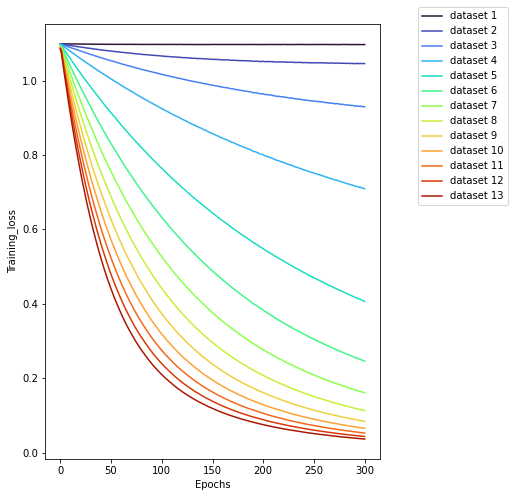

In [24]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1),color = cm(i*20))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))